<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg"  width=400></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Домашнее задание. Обучение нейронных сетей на PyTorch.

В этом домашнем задании вам предстоит предсказывать типы небесных объектов. Эту задачу вы будете решать с помощью нейронных сетей, используя библиотеку PyTorch. 

Вам необходимо заполнить пропуски в ноутбуке. Кое-где вас просят сделать выводы о проделанной работе. Постарайтесь ответить на вопросы обдуманно и развёрнуто. 


***В этом домашнем задании мы используем новый метод проверки --- Peer Review.***

Peer Review — альтернативный способ проверки ваших заданий, который подразумевает, что после сдачи задания у вас появится возможность (и даже моральная обязанность, но не строгое обязательство) проверить задания нескольких ваших однокурсников. Соответственно, и ваши работы будут проверять другие учащиеся курса. Для выставления оценки необходимо будет, чтобы вашу работу проверило по крайней мере 3 ваших однокурсника. Вы же, выступая в роли проверяющего, сможете узнать больше о выполненном задании, увидеть, как его выполняли другие. 

Чем больше заданий однокурсников вы проверите, тем лучше! Но, пожалуйста, проверяйте внимательно. По нашим оценкам, на проверку одной работы у вас уйдёт 5-10 минут. Подробные инструкции для проверки заданий мы пришлём позже.

***ВАЖНО!*** Чтобы задание было удобнее проверять, необходимо сдать на Stepik два файла: файл в формате .ipynb и файл в формате .pdf. Файл .pdf можно получить, открыв File->Print и выбрать "Save as PDF". Аналогичный способ есть и в Jupyter.


In [85]:
import torch
from torch import nn
from torch import functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Дисклеймер про CrossEntropyLoss и NLLLoss

Обычно в PyTorch не нужно делать Softmax как последний слой модели. 

* Если Вы используете NLLLoss, то ему на вход надо давать лог вероятности, то есть выход слоя LogSoftmax. (Просто результат софтмакса, к которому применен логарифм)
* Если Вы используете CrossEntropyLoss, то применение LogSoftmax уже включено внутрь лосса, поэтому ему на вход надо подавать просто выход обычного линейного слоя без активации. По сути CrossEntropyLoss = LogSoftmax + NLLLoss

Зачем такие сложности, чтобы посчитать обычную кросс энтропию, которую мы использовали как лосс еще в логистической регрессии? Дело в том, что нам в любом случае придется взять логарифм от результатов софтмакса, а если делать это одной функцией, то можно сделать более устойчивую реализацию, которая даст меньшую вычислительную погрешность. 

Таким образом, если у вас в конце сети, решающей задачу классификации, стоит просто линейный слой без активации, то вам нужно использовать CrossEntropy. В этой домашке везде используется лосс CrossEntropy

# 0. Fix data type and device for this notebook

In [86]:
# check for CUDA availability (NVIDIA GPU)
if torch.cuda.is_available():
    # get the CUDA device name
    device = torch.device('cuda')          # CUDA-device object
else:
    device = torch.device('cpu')           # cpu-device object

print(device)

cuda


In [87]:
# fix the data types for data (X) and label (y)

data_dtype = torch.float32
print('data_dtype:', data_dtype)

label_dtype = torch.int64
print('label_dtype:', label_dtype)

data_dtype: torch.float32
label_dtype: torch.int64


# Задание 1. Создайте генератор батчей. 

В этот раз мы хотим сделать генератор, который будет максимально похож на то, что используется в реальном обучении. 

С помощью numpy вам нужно перемешать исходную выборку и выбирать из нее батчи размером batch_size, если размер выборки не делился на размер батча, то последний батч должен иметь размер меньше batch_size и состоять просто из всех оставшихся объектов. Возвращать нужно в формате (X_batch, y_batch). Необходимо написать именно генератор, то есть вместо return использовать yield. 

Хорошая статья про генераторы: https://habr.com/ru/post/132554/


**Ответ на задание - код**


In [88]:
def batch_generator(X, y, batch_size):

    # basic info about X
    n = len(X)
    num_full_batches = n // batch_size
    rest = n % batch_size

    # shuffle the data before yielding batches
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    X_shuffled = X[perm, :]
    y_shuffled = y[perm]

    # yielding num_full_batches, each of size=batch_size
    for i in range(num_full_batches):
        yield X_shuffled[i * batch_size : (i+1) * batch_size, :], y_shuffled[i * batch_size : (i+1) * batch_size]
    
    # yelding the last (not full) batch if needed
    if rest != 0:
        yield X_shuffled[-rest:, :], y_shuffled[-rest:]

## Тестируем наш batch_generator вручную

In [89]:
n = 10
batch_size = 4

In [90]:
np.random.seed(0)
a = np.hstack((np.arange(n)[:, np.newaxis], np.ones(n)[:, np.newaxis], np.random.randint(0, 10*n, n)[:, np.newaxis]))
a

array([[ 0.,  1., 44.],
       [ 1.,  1., 47.],
       [ 2.,  1., 64.],
       [ 3.,  1., 67.],
       [ 4.,  1., 67.],
       [ 5.,  1.,  9.],
       [ 6.,  1., 83.],
       [ 7.,  1., 21.],
       [ 8.,  1., 36.],
       [ 9.,  1., 87.]])

In [91]:
b = np.arange(10) * 2
b

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [92]:
np.random.seed(42)
perm = np.random.permutation(len(a))

print(perm)

[8 1 5 0 7 2 9 4 3 6]


In [93]:
a_shuffled = a[perm, :]
a_shuffled

array([[ 8.,  1., 36.],
       [ 1.,  1., 47.],
       [ 5.,  1.,  9.],
       [ 0.,  1., 44.],
       [ 7.,  1., 21.],
       [ 2.,  1., 64.],
       [ 9.,  1., 87.],
       [ 4.,  1., 67.],
       [ 3.,  1., 67.],
       [ 6.,  1., 83.]])

In [94]:
rest = n % batch_size
rest

2

In [95]:
a_shuffled[-rest:, ]

array([[ 3.,  1., 67.],
       [ 6.,  1., 83.]])

In [96]:
gen = batch_generator(X=a, y=b, batch_size=5)
for _ in gen:
    print(_)

(array([[ 8.,  1., 36.],
       [ 1.,  1., 47.],
       [ 5.,  1.,  9.],
       [ 0.,  1., 44.],
       [ 7.,  1., 21.]]), array([16,  2, 10,  0, 14]))
(array([[ 2.,  1., 64.],
       [ 9.,  1., 87.],
       [ 4.,  1., 67.],
       [ 3.,  1., 67.],
       [ 6.,  1., 83.]]), array([ 4, 18,  8,  6, 12]))


## Тесты от deep learning school

Попробуем потестировать наш код

In [97]:
from inspect import isgeneratorfunction
assert isgeneratorfunction(batch_generator), "batch_generator должен быть генератором! В условии есть ссылка на доки"

X = np.array([
              [1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]
])
y = np.array([
              1, 2, 3
])

# Проверим shape первого батча
iterator = batch_generator(X, y, 2)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (2, 3), y_batch.shape == (2,)
assert np.allclose(X_batch, X[:2]), np.allclose(y_batch, y[:2])

# Проверим shape последнего батча (их всего два)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (1, 3), y_batch.shape == (1,)
assert np.allclose(X_batch, X[2:]), np.allclose(y_batch, y[2:])

# Проверим, что итерации закончились
iter_ended = False
try:
    next(iterator)
except StopIteration:
    iter_ended = True
assert iter_ended

# Еще раз проверим то, сколько батчей создает итератор
X = np.random.randint(0, 100, size=(1000, 100))
y = np.random.randint(-1, 1, size=(1000, 1))
num_iter = 0
for _ in batch_generator(X, y, 3):
    num_iter += 1
assert num_iter == (1000 // 3 + 1)

# Задание 2. Обучите модель для классификации звезд

Загрузите датасет из файла sky_data.csv, разделите его на train/test и обучите на нем нейронную сеть (архитектура ниже). Обучайте на батчах с помощью оптимизатора Adam, lr подберите сами, пробуйте что-то вроде 1e-2

Архитектура:

1. Dense Layer с relu активацией и 50 нейронами
2. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте 50%) 
3. BatchNorm
4. Dense Layer с relu активацией и 100 нейронами
5. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте для разнообразия 50%)
6. BatchNorm
7. Выходной Dense слой c количеством нейронов, равному количеству классов

Лосс - CrossEntropy.

В датасете классы представлены строками, поэтому классы нужно закодировать. Для этого в строчке ниже объявлен dict, с помощью него и функции map превратите столбец с таргетом в целое число. Кроме того, за вас мы выделили признаки, которые нужно использовать.

### Загрузка и обработка данных

In [98]:
feature_columns = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field']
target_column = 'class'

target_mapping = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}

In [99]:
data = pd.read_csv('https://drive.google.com/uc?id=1K-8CtATw6Sv7k2dXco1fL5MAhTbKtIH3')
data['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [100]:
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [101]:
# Extract Features
X = data[feature_columns]
# Extract target
y = data[target_column].copy()

In [102]:
# encode target with target_mapping
y.replace(target_mapping, inplace=True)
y.value_counts() # check the results

0    4998
1    4152
2     850
Name: class, dtype: int64

Нормализация фичей

In [103]:
print("Mean by col: \n", X.mean(axis=0), "\n")
print("Std by col: \n", X.std(axis=0))

Mean by col: 
 ra        175.529987
dec        14.836148
u          18.619355
g          17.371931
r          16.840963
i          16.583579
z          16.422833
run       981.034800
camcol      3.648700
field     302.380100
dtype: float64 

Std by col: 
 ra         47.783439
dec        25.212207
u           0.828656
g           0.945457
r           1.067764
i           1.141805
z           1.203188
run       273.305024
camcol      1.666183
field     162.577763
dtype: float64


In [104]:
# Просто вычтите среднее и поделитe на стандартное отклонение (с помощью пандас). Также преобразуйте всё в np.array

# # v1 
# X = X.to_numpy()
# X = (X - X.mean(axis=0)) / X.std(axis=0)

# v2
X = (X - X.mean(axis=0)) / X.std(axis=0, ddof=0)
X = X.to_numpy()

y = y.to_numpy()

In [105]:
print("Mean by col: \n", np.round(X.mean(axis=0), 5), "\n")
print("Std by col: \n", X.std(axis=0))

Mean by col: 
 [ 0. -0.  0.  0.  0.  0. -0. -0.  0. -0.] 

Std by col: 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [106]:
assert type(X) == np.ndarray and type(y) == np.ndarray, 'Проверьте, что получившиеся массивы являются np.ndarray'
assert np.allclose(y[:5], [1,1,0,1,1])
assert X.shape == (10000, 10)
assert np.allclose(X.mean(axis=0), np.zeros(10)) and np.allclose(X.std(axis=0), np.ones(10)), 'Данные не отнормированы'


Обучение

In [107]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Превратим данные в тензоры, чтобы потом было удобнее
X_train = torch.tensor(X_train, dtype=data_dtype, device=device)
y_train = torch.tensor(y_train, dtype=label_dtype, device=device)
X_test = torch.tensor(X_test, dtype=data_dtype, device=device)
y_test = torch.tensor(y_test, dtype=label_dtype, device=device)

In [108]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print()

print("X_train.dtype: ", X_train.dtype)
print("y_train.dtype: ", y_train.dtype)
print()

print("X_train.device: ", X_train.device)
print("y_train.device: ", y_train.device)
print()

print("X_train.requires_grad: ", X_train.requires_grad)
print("y_train.requires_grad: ", y_train.requires_grad)

X_train.shape:  torch.Size([7500, 10])
y_train.shape:  torch.Size([7500])

X_train.dtype:  torch.float32
y_train.dtype:  torch.int64

X_train.device:  cuda:0
y_train.device:  cuda:0

X_train.requires_grad:  False
y_train.requires_grad:  False


Хорошо, данные мы подготовили, теперь надо объявить модель.

Обучайте на батчах с помощью оптимизатора Adam, lr подберите сами, пробуйте что-то вроде 1e-2

Архитектура:

1. Dense Layer с relu активацией и 50 нейронами
2. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте 50%) 
3. BatchNorm
4. Dense Layer с relu активацией и 100 нейронами
5. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте для разнообразия 50%)
6. BatchNorm
7. Выходной Dense слой c количеством нейронов, равному количеству классов

Лосс - CrossEntropy.

> Indented block



In [109]:
torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(in_features=10, out_features=50),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.BatchNorm1d(50),

    nn.Linear(in_features=50, out_features=100),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.BatchNorm1d(num_features=100),
    
    nn.Linear(in_features=100, out_features=3)
)

# put the model on the same device where we have the data
model = model.to(device)

In [110]:
# specify loss function, learning rate, and learning rate optimizer
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Обучающий цикл

In [111]:
def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []

    for i in range(num_epoch):
        epoch_train_losses = []

        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            # На лекции мы рассказывали, что дропаут работает по-разному во время обучения и реального предсказания
            # Чтобы это учесть нам нужно включать и выключать режим обучения, делается это командой ниже
            model.train(True)
            
            # Посчитаем предсказание и лосс
            pred_batch = model(X_batch)
            batch_loss = loss_fn(pred_batch, y_batch)
            
            # зануляем градиент
            optimizer.zero_grad()
            
            # backward
            batch_loss.backward()
            
            # ОБНОВЛЯЕМ веса
            optimizer.step()
            
            # Запишем число (не тензор) в наши батчевые лоссы
            epoch_train_losses.append(batch_loss.item())
                    
        train_losses.append(np.mean(epoch_train_losses))

        # Теперь посчитаем лосс на тесте
        model.train(False)
        with torch.no_grad():
            # Сюда опять же надо положить именно число равное лоссу на всем тест датасете
            pred_test = model(X_test)
            test_loss = loss_fn(pred_test, y_test)

            test_losses.append(test_loss.item())
            
    return train_losses, test_losses

In [112]:
def check_loss_decreased():
    print("На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]")
    s = input()
    if s.lower() == 'да':
        print("Хорошо!")
    else:
        raise RuntimeError("Можно уменьшить дропаут, уменьшить lr, поправить архитектуру, etc")

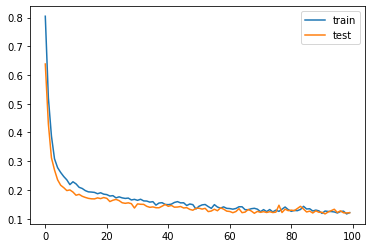

In [113]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, num_epoch=100) #Подберите количество эпох так, чтобы график loss сходился
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
# check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3

### Вычислите accuracy получившейся модели на train и test

In [114]:
# setting the model into the evaluation mode (for Dropout and BatchNorm)
model.eval()

# saving the preidcted labels for train and test sets
train_pred_labels = torch.max(model.forward(X_train).detach(), 1)[1]
test_pred_labels = torch.max(model.forward(X_test).detach(), 1)[1]

In [115]:
train_pred_labels

tensor([1, 1, 1,  ..., 0, 1, 1], device='cuda:0')

In [116]:
y_train

tensor([1, 1, 1,  ..., 0, 1, 1], device='cuda:0')

In [117]:
from sklearn.metrics import accuracy_score

In [118]:
train_acc = accuracy_score(y_true=y_train.cpu(), y_pred=train_pred_labels.cpu())
test_acc = accuracy_score(y_true=y_test.cpu(), y_pred=test_pred_labels.cpu())

assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))

Train accuracy: 0.9724
Test accuracy: 0.9612


# Задание 3. Исправление ошибок в архитектуре

Только что вы обучили полносвязную нейронную сеть. Теперь вам предстоит проанализировать архитектуру нейронной сети ниже, исправить в ней ошибки и  обучить её с помощью той же функции train. Пример исправления ошибок есть в семинаре Григория Лелейтнера.

Будьте осторожнее и убедитесь, что перед запуском train вы вновь переопределили все необходимые внешние переменные (train обращается к глобальным переменным, в целом так делать не стоит, но сейчас это было оправдано, так как иначе нам пришлось бы передавать порядка 7-8 аргументов).

Чтобы у вас получилась такая же архитектура, как у нас, и ответы совпали, давайте определим некоторые правила, как исправлять ошибки:

1. Если вы видите лишний нелинейный слой, который стоит не на своем месте, просто удалите его. (не нужно добавлять новые слои, чтобы сделать постановку изначального слоя разумной. Удалять надо самый последний слой, который все портит. Для линейных слоев надо что-то исправить, а не удалить его)
2. Если у слоя нет активации, то добавьте ReLU или другую подходящую активацию
3. Если что-то не так с learning_rate, то поставьте 1e-2
4. Если что-то не так с параметрами, считайте первый параметр, который появляется, как верный (т.е. далее в сети должен использоваться он).
5. Ошибки могут быть и в полносвязных слоях. 
6. Любые другие проблемы решаются более менее однозначно, если же у вас есть серьезные сомнения, то напишите в беседу в телеграме и пинганите меня @runfme


Задача все та же - классификация небесных объектов на том же датасете. После исправления сети вам нужно обучить ее.

**Ответ на задачу - средний лосс на тестовом датасете**

In [119]:
torch.manual_seed(42)   
np.random.seed(42)
# WRONG ARCH
model = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(6, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(100, 200),
    nn.Softmax(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
    nn.Dropout(p=0.5)
)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-100)

In [120]:
# RIGHT ARCH
torch.manual_seed(42)   
np.random.seed(42)

model = nn.Sequential(
    nn.Linear(len(feature_columns), 100),
    nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(100, 200),
    nn.ReLU(),

    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    
    nn.Linear(200, 3),
)

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

### Обучите и протестируйте модель так же, как вы это сделали в задаче 2. Вычислите accuracy.

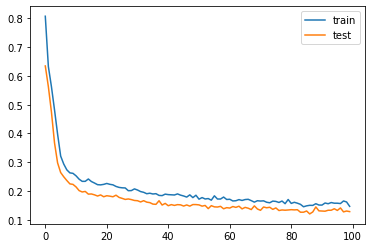

In [121]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, num_epoch=100) #Подберите количество эпох так, чтобы график loss сходился
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
# check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3

In [122]:
# setting the model into the evaluation mode (for Dropout and BatchNorm)
model.eval()

# saving the preidcted labels for train and test sets
# torch.max returns a tuple (values, indices) = (max, argmax), so we take the
# indices by subsetting to [1]
train_pred_labels = torch.max(model.forward(X_train).detach(), 1)[1]
test_pred_labels = torch.max(model.forward(X_test).detach(), 1)[1]

In [123]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_true=y_train.cpu(), y_pred=train_pred_labels.cpu())
test_acc = accuracy_score(y_true=y_test.cpu(), y_pred=test_pred_labels.cpu())

assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))

Train accuracy: 0.9685333333333334
Test accuracy: 0.9572


# Задание 4. Stack layers

Давайте посмотрим, когда добавление перестает улучшать метрики. Увеличивайте блоков из слоев в сети, пока минимальный лосс на тестовом датасете за все время обучения не перестанет уменьшаться (20 эпох). 

Стоит помнить, что нельзя переиспользовать слои с предыдущих обучений, потому что они уже будут с подобранными весами.

**Чтобы получить воспроизводимость и идентичный нашему ответ, надо объявлять все слои в порядке, в котором они применяются внутри модели. Это важно, если вы будете собирать свою модель из частей. Перед объявлением этих слоев по порядку напишите**
> torch.manual_seed(42)   
> np.random.seed(42)

**При чем каждый раз, когда вы заново создаете модель, перезадавайте random seeds**

**Опитимизатор - Adam(lr=1e-2)**


In [124]:
# МОДЕЛЬ ДЛЯ ПРИМЕРА, НА САМОМ ДЕЛЕ ВАМ ПРИДЕТСЯ СОЗДАВАТЬ НОВУЮ МОДЕЛЬ ДЛЯ КАЖДОГО КОЛИЧЕСТВА БЛОКОВ
model = nn.Sequential(
    nn.Linear(len(feature_columns), 100),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    # Начало блока, который надо вставалять много раз
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    # Конец блока
    nn.Linear(100, 3)
    # Блока Softmax нет, поэтому нам нужно использовать лосс - CrossEntropyLoss
)

In [125]:
# Вы уже многое умеете, поэтому теперь код надо написать самому
# Идея - разделить модель на части.
# Вначале создать head часть как Sequential модель, потом в цикле создать Sequential модели, которые представляют
# из себя блоки, потом создать tail часть тоже как Sequential, а потом объединить их в одну Sequential модель 
# вот таким кодом: nn.Sequential(header, *blocks, footer)
# Важная идея тут состоит в том, что модели могут быть частями других моделей)

In [126]:
# choose up till which number of blocks to try in the model
max_num_blocks = 10

## Решение с конструкторами

In [127]:
def head_constructor():
    head = nn.Sequential(
        nn.Linear(len(feature_columns), 100),
        nn.ReLU(),
        nn.Dropout(p=0.5),
    )
    return head

# constracting one block to reuse
def block_constructor():
    block = nn.Sequential(
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
    )
    return block

# constracting the tail
def tail_constructor():
    return nn.Sequential(nn.Linear(100, 3))  


In [128]:
%%time

# record the losses here
min_test_losses = []
min_train_losses = []

for num_blocks in range(max_num_blocks):

    print("Fitting the model with {} blocks".format(num_blocks))
    
    # creating the model
    torch.manual_seed(42)
    np.random.seed(42)
    model = nn.Sequential(head_constructor(),
                          *[block_constructor() for _ in range(num_blocks)],
                          tail_constructor())
    model = model.to(device)

    # loss and optimimzer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    # training the model
    train_losses, test_losses = train(X_train, y_train, X_test, y_test, num_epoch=20)

    min_test_losses.append(np.min(test_losses))
    min_train_losses.append(np.min(train_losses))

    # # plotting train and test loss curves for each model
    # plt.plot(range(len(train_losses)), train_losses, label='train')
    # plt.plot(range(len(test_losses)), test_losses, label='test')
    # plt.title("Loss curves for {} blocks".format(num_blocks))
    # plt.legend()
    # plt.show()

Fitting the model with 0 blocks
Fitting the model with 1 blocks
Fitting the model with 2 blocks
Fitting the model with 3 blocks
Fitting the model with 4 blocks
Fitting the model with 5 blocks
Fitting the model with 6 blocks
Fitting the model with 7 blocks
Fitting the model with 8 blocks
Fitting the model with 9 blocks
CPU times: user 24.5 s, sys: 247 ms, total: 24.8 s
Wall time: 24.9 s


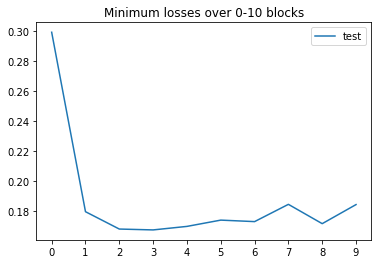

[0.29913777112960815,
 0.17947514355182648,
 0.1679074764251709,
 0.167328879237175,
 0.16967494785785675,
 0.17386330664157867,
 0.17286652326583862,
 0.18437838554382324,
 0.17150373756885529,
 0.18422427773475647]

In [129]:
# choose up to which number of losses to plot to
# needed not to retrain the model just to get a different plot
up_to = min(100, max_num_blocks)

plt.plot(np.arange(up_to), min_test_losses[:up_to], label='test')
plt.xticks(np.arange(up_to))
plt.title("Minimum losses over 0-{} blocks".format(up_to))
plt.legend()
plt.show()

min_test_losses[:up_to]

## Решение через <blocks.append(block)>

In [130]:
def make_model(num_blocks):
    print("Creating a model with {} blocks".format(num_blocks))

    # fixing the random seeds for reprodusability
    torch.manual_seed(42)
    np.random.seed(42)

    # head of the model
    head = nn.Sequential(
        nn.Linear(len(feature_columns), 100),
        nn.ReLU(),
        nn.Dropout(p=0.5),
    )

    # blocks to use
    blocks = []
    for _ in range(num_blocks):

        block = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
        )

        blocks.append(block)

    # tail of the model
    tail = nn.Sequential(
        nn.Linear(100, 3)
    )    

    # creating the model
    model = nn.Sequential(head, *blocks, tail)

    model.to(device)

    return model

In [131]:
%%time

# record the losses here
min_test_losses = []
min_train_losses = []


for num_blocks in range(max_num_blocks):

    # create the model
    model = make_model(num_blocks)

    # loss and optimimzer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    # traine the model
    train_losses, test_losses = train(X_train, y_train, X_test, y_test, num_epoch=20)

    # record the losses
    min_test_losses.append(np.min(test_losses))
    min_train_losses.append(np.min(train_losses))

    # # plot the train and test loss curves
    # plt.plot(range(len(train_losses)), train_losses, label='train')
    # plt.plot(range(len(test_losses)), test_losses, label='test')
    # plt.title("Loss curves for {} blocks".format(num_blocks))
    # plt.legend()
    # plt.show()


Creating a model with 0 blocks
Creating a model with 1 blocks
Creating a model with 2 blocks
Creating a model with 3 blocks
Creating a model with 4 blocks
Creating a model with 5 blocks
Creating a model with 6 blocks
Creating a model with 7 blocks
Creating a model with 8 blocks
Creating a model with 9 blocks
CPU times: user 24.4 s, sys: 250 ms, total: 24.6 s
Wall time: 24.8 s


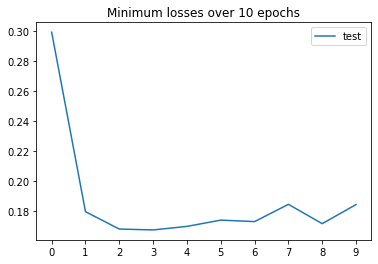

[0.27575019200642903,
 0.20317469239234925,
 0.19531993865966796,
 0.20077314476172128,
 0.19970435798168182,
 0.20574029684066772,
 0.2092691997687022,
 0.21562907099723816,
 0.21048808693885804,
 0.2173848142226537]

In [132]:
# choose up to which number of losses to plot to
# needed not to retrain the model just to get a different plot
up_to = 10
assert up_to <= max_num_blocks

# plt.plot(range(len(min_test_losses)), min_test_losses, label='test')
plt.plot(np.arange(up_to), min_test_losses[:up_to], label='test')
plt.xticks(np.arange(up_to))
plt.title("Minimum losses over {} epochs".format(up_to))
plt.legend()
plt.show()

min_train_losses[:up_to]

## Примеры создания листов с блоками

### Интуитивный, но неверный способ

В итоге получается лист с элементами, referencing один и тот же объект. Это приводит к проблемам во время тренировки модели (обратное распространение ошибки / backpropagation работает не так, как надо).

In [133]:
# blocks to use
block = nn.Sequential(
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
)

blocks = [block for _ in range(5)]

[id(_) for _ in blocks]

[139927138893952,
 139927138893952,
 139927138893952,
 139927138893952,
 139927138893952]

### Верный, но совсем не элегантный способ

Заметим, что references у объектов уже разные в отличие от предыдущего пункта

In [134]:
# blocks to use
blocks = []
for _ in range(5):
    block = nn.Sequential(
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100)
    )

    blocks.append(block)


[id(_) for _ in blocks]
del(blocks)

### Верный и элегантный способ через конструкторы

По крайней мере мне очень нравится

In [135]:
# blocks to use
def block_constructor():
    b = nn.Sequential(
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
    )
    return b

blocks = [block_constructor() for _ in range(5)]

[id(_) for _ in blocks]
del(blocks)

## Задание 5. Сделайте выводы 
Начиная с какого количества блоков минимальный лосс за время обучения увеличивается? Почему лишнее количество блоков не помогает модели? 

Заметим, при увеличении числа блоков модель становится сложнее и сильнее.

**Начиная с какого количества блоков минимальный лосс за время обучения увеличивается?**

Модель с 5 блоками на 20 эпохах показывает лчший результат на тестовой выборке, начиная с 5 блоков минимальный лосс за время обучения чаще всего увеличивается.

(С 1 блока до 2 блоков, и с 3 блоков до 4 блоков идет небольшое увеличение лосса, но минимальный все же достигается на 5 блоках).

**Почему лишнее количество блоков не помогает модели?**

Это может происходить по 2 причинам:
1. Более сильная модель может переобучиться на train set, что приводит к увеличению ошибки на test set. Но эта причина не ввыдерживает критики, когда мы смотрим на график min_train_losses, потому что train loss показывает лучший результат с тремя блоками, и начинает расти. 
2. Вторая возможная причина, это то, что при увеличении количества блоков, наша модель становится сильнее и ей уже не хватает 20 эпох для обучения. При увеличении количества эпох до 100, для test set и для train set минимальный лосс наблюдается для моделей с 2, и 3 блоками соответственно. При этом лосс падает в принципе: колебания лосса теперь между 0.11 и 0.14 для моделей с 1-10 блоками по сравнению с колебаниями между 0.16 и 0.18 для этих е моделей треннированных на 20 эпохах.

**Вывод:**
Сложность данных соответствует сложности модели с 2-5 такими блоками, как даны в задании. При увеличении количества блоков больше 5 мы не добавляем модели ничего полезного, а только увеличивем количество эпох, нужных чтобы обучить эти модели до такого-же результата (большие и сложные модели нужно дольше учить). Для улучшения качества можно попробовать изменить блок (добавить Dropout или изменить количество нейронов в слое).